
# Conflicts and versions 

Conflicts are an essential part of any distributed system. 
Conflicts arise when there are two or more valid versions of the same message.

As we've seen from the previous notebooks, the network can be unreliable: there may be longer delays. But what about faults/conflicts from the clients/message producers? Moreover, a message might have multiple valid versions.  It could be that peers received two versions of the message, both being signed and valid. What version to choose? What to do when an order of the message is important? 



In [693]:
# Initialize the experiment:
import networkx as nx
import p2psimpy as p2p
import warnings
warnings.filterwarnings('ignore')

# Load the previous experiment configurations
exper = p2p.BaseSimulation.load_experiment(expr_dir='crash_gossip')

Locations, topology, peer_services, serv_impl = exper


## Client generating conflicting information

Let's assign first adversary nodes, we will assign randomly: 

In [694]:
import random
import string

from p2psimpy import BaseMessage, GossipMessage, MessageProducer, PullGossipService

from p2psimpy.consts import TEMPERED
from p2psimpy.config import Config, Func, Dist

class Transaction(BaseMessage):
    pass 

class ConflictMessageProducer(MessageProducer):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.balance = 100 
        
        
    def _generate_tx(self):        
        msg_phash = ''.join(random.choices(string.ascii_uppercase, k=20))
        diff = random.randint(1, 9)        
        data = {'hash': msg_phash, 'balance': self.balance-diff, 'diff': diff}
        tx = Transaction(self.peer, data)
        
        msg_id = '_'.join((str(self.peer.peer_id), str(self.counter)))
        msg_ttl = self.init_ttl
        return GossipMessage(self.peer, msg_id, tx, msg_ttl, 
            pre_task=self.pre_task, post_task=self.post_task)
    
    def produce_transaction(self):
        # generate new transaction
        msg = self._generate_tx()
        if self.balance - msg.data.data['diff'] < 0:
            return
        
        cons = list(self.peer.connections.keys())
        m_ix = len(cons) // 2
        for p in cons[:m_ix]:
            self.peer.send(p, msg)
            
        # Generate conflicting message as if previous transaction hasn't happened  
        msg = self._generate_tx()
        for p in cons[m_ix:]:
            self.peer.send(p, msg)
        
        self.peer.store('msg_time', str(self.peer.peer_id) +'_' + str(self.counter), self.peer.env.now)
        self.peer.store('msg_data', str(self.peer.peer_id) + '_' + str(self.counter), msg)
        self.balance -= msg.data.data['diff']
        self.counter+=1

def validate_task(msg, peer):
    # time it takes to verify the signature
    crypto_verify = Dist('norm', (1, 0.2)) 
    # time to verify the message data
    msg_verify = Dist("lognorm", (0.49512563, 4.892564, 0.0425785)) 
    
    yield peer.env.timeout(crypto_verify.get() + msg_verify.get())
    if isinstance(msg, Transaction):        
        tx = msg.data
        if tx == TEMPERED or tx['balance'] < 0:
            # You can decide what to do in this case.
            return False
    return True


class MsgConfig(Config):
    pre_task = Func(validate_task)
    
peer_services['client'].service_map['MessageProducer'] = MsgConfig
serv_impl['MessageProducer'] = ConflictMessageProducer
serv_impl['RangedPullGossipService'] = PullGossipService

## Run simulation 

Let's see how adversarial agents together with crashing nodes affect the message dissemination. 

In [695]:
peer_services

{'client': PeerType(config=<class 'p2psimpy.config.PeerConfig'>, service_map={'BaseConnectionManager': None, 'MessageProducer': <class '__main__.MsgConfig'>}),
 'peer': PeerType(config=<class 'p2psimpy.config.PeerConfig'>, service_map={'BaseConnectionManager': None, 'RandomDowntime': <class 'p2psimpy.config.DowntimeConfig'>, 'RangedPullGossipService': <class 'p2psimpy.config.GossipConfig'>})}

In [696]:
serv_impl

{'BaseConnectionManager': p2psimpy.services.connection_manager.BaseConnectionManager,
 'MessageProducer': __main__.ConflictMessageProducer,
 'RandomDowntime': p2psimpy.services.disruption.RandomDowntime,
 'RangedPullGossipService': p2psimpy.services.gossip.PullGossipService}

In [697]:
# Init Graph
sim = p2p.BaseSimulation(Locations, topology, peer_services, serv_impl)
sim.run(5_200)

## Message analysis

Let's see how this fraction of adverserial nodes affected the network. 


In [698]:
import pandas as pd

def message_data(sim, peer_id, storage_name):
    store = sim.peers[peer_id].storage[storage_name].txs
    for msg_id, tx in store.items():
        client_id, msg_num = msg_id.split('_')
        client_tx = sim.peers[int(client_id)].storage[storage_name].txs[msg_id]
        yield (int(msg_num), tx.data == client_tx.data)
        
def get_gossip_table(sim, storage_name, func):
    return pd.DataFrame({k: dict(func(sim, k, storage_name)) 
                         for k in set(sim.types_peers['peer'])}).sort_index()

    
df = get_gossip_table(sim, 'msg_data', message_data)
df

1      2      3      4      5      6      7      8      9      10  ...  \
1    True  False   True   True  False   True  False   True   True   True  ...   
2    True   True  False   True  False   True  False   True   True  False  ...   
3    True  False   True   True  False   True  False   True   True  False  ...   
4    True  False   True   True  False   True  False   True   True   True  ...   
5    True  False   True   True  False   True  False   True   True   True  ...   
6    True  False   True   True  False   True  False   True  False   True  ...   
7    True  False  False   True  False  False  False   True   True   True  ...   
8    True  False   True  False  False   True  False   True   True  False  ...   
9    True  False   True  False  False   True  False   True   True  False  ...   
10   True  False  False   True  False   True  False   True   True  False  ...   
11   True  False  False   True  False   True  False   True   True   True  ...   
12   True  False  False  False  False   True  False   True   True  False  ...   
13   True  False  False   True  False   True  False   True   True  False  ...   
14   True  False  False   True  False   True   True   True   True  False  ...   
15   True  False  False   True  False   True  False   True   True  False  ...   
16   True  False  False  False   True  False  False  False    NaN  False  ...   
17  False  False  False  False  False   True  False  False    NaN  False  ...   
18   True  False   True   True  False   True  False   True   True  False  ...   
19   True    NaN   True   True  False   True  False   True   True   True  ...   
20   True    NaN    NaN    NaN  False  False  False    NaN    NaN   True  ...   
21    NaN    NaN    NaN    NaN  False   True  False    NaN   True   True  ...   

       16     17     18     19     20     21     22     23     24     25  
1   False   True  False  False   True   True   True   True  False  False  
2   False  False  False  False  False   True   True   True  False  False  
3   False   True   True  False  False   True   True   True  False   True  
4   False   True   True  False  False   True   True   True  False   True  
5   False   True   True  False  False   True   True  False  False  False  
6   False   True   True  False  False   True   True  False  False  False  
7   False   True   True  False  False   True   True  False  False   True  
8   False   True  False  False  False  False  False   True  False   True  
9   False  False  False  False  False  False  False   True  False   True  
10   True   True  False  False   True   True   True   True  False  False  
11   True   True   True   True   True   True   True   True  False   True  
12   True   True  False   True   True   True   True   True  False   True  
13  False   True   True  False  False   True  False  False  False  False  
14  False   True   True  False  False   True   True  False   True  False  
15   True  False   True  False   True  False   True   True  False  False  
16   True  False   True  False   True  False   True  False  False  False  
17   True  False  False  False   True  False   True  False  False  False  
18  False  False  False  False  False  False  False   True  False    NaN  
19   True    NaN   True  False  False    NaN   True   True   True    NaN  
20  False    NaN   True  False    NaN    NaN   True    NaN  False    NaN  
21  False    NaN    NaN  False    NaN    NaN   True    NaN  False    NaN  

[21 rows x 25 columns]

In [699]:
df[df==False].count()

1      1
2     17
3     10
4      5
5     20
6      3
7     20
8      2
9      1
10    12
11     1
12     6
13     2
14    21
15    11
16    14
17     6
18     8
19    19
20    12
21     6
22     4
23     7
24    19
25    10
dtype: int64

In [700]:
sim.peers[1].storage['msg_data'].txs

{'26_1': GossipMessage:Transaction:{'hash': 'ZRGPKCEHJHNZGLUMAWQX', 'balance': 91, 'diff': 9},
 '26_2': GossipMessage:Transaction:{'hash': 'JAIITZPPGPBPOYJWBAQF', 'balance': 82, 'diff': 9},
 '26_3': GossipMessage:Transaction:{'hash': 'SWKLIOFRZURWBVUBIHYO', 'balance': 78, 'diff': 4},
 '26_4': GossipMessage:Transaction:{'hash': 'BPMYUJVXTAYQSQFJSOWD', 'balance': 77, 'diff': 1},
 '26_5': GossipMessage:Transaction:{'hash': 'ZHWONMEIPZPCZRYFCVWI', 'balance': 76, 'diff': 1},
 '26_6': GossipMessage:Transaction:{'hash': 'JYVLGHGVEOGJKDIVYFEM', 'balance': 74, 'diff': 2},
 '26_7': GossipMessage:Transaction:{'hash': 'OQYAWQIONGVMJJXEMLKJ', 'balance': 71, 'diff': 3},
 '26_8': GossipMessage:Transaction:{'hash': 'CTXDWVPNZSMORWAGYPKZ', 'balance': 70, 'diff': 1},
 '26_9': GossipMessage:Transaction:{'hash': 'BTISXETEVXABHQYCSIFS', 'balance': 63, 'diff': 7},
 '26_10': GossipMessage:Transaction:{'hash': 'RKQPLCAZIBXOCLMIBJRK', 'balance': 58, 'diff': 5},
 '26_11': GossipMessage:Transaction:{'hash': 'WJC

In [701]:
sim.peers[3].storage['msg_data'].txs

{'26_1': GossipMessage:Transaction:{'hash': 'ZRGPKCEHJHNZGLUMAWQX', 'balance': 91, 'diff': 9},
 '26_2': GossipMessage:Transaction:{'hash': 'YFTUMHTKGBMZXBQANOVM', 'balance': 88, 'diff': 3},
 '26_3': GossipMessage:Transaction:{'hash': 'SWKLIOFRZURWBVUBIHYO', 'balance': 78, 'diff': 4},
 '26_4': GossipMessage:Transaction:{'hash': 'BPMYUJVXTAYQSQFJSOWD', 'balance': 77, 'diff': 1},
 '26_6': GossipMessage:Transaction:{'hash': 'JYVLGHGVEOGJKDIVYFEM', 'balance': 74, 'diff': 2},
 '26_5': GossipMessage:Transaction:{'hash': 'ZHWONMEIPZPCZRYFCVWI', 'balance': 76, 'diff': 1},
 '26_7': GossipMessage:Transaction:{'hash': 'WCYXDAQBRERMWGNVBBFW', 'balance': 70, 'diff': 4},
 '26_8': GossipMessage:Transaction:{'hash': 'CTXDWVPNZSMORWAGYPKZ', 'balance': 70, 'diff': 1},
 '26_9': GossipMessage:Transaction:{'hash': 'BTISXETEVXABHQYCSIFS', 'balance': 63, 'diff': 7},
 '26_10': GossipMessage:Transaction:{'hash': 'LPRDTOTOGGZBHIZVVFUN', 'balance': 62, 'diff': 1},
 '26_11': GossipMessage:Transaction:{'hash': 'EVO

Peers see different versions of the same message!
This is an issue as it might violate integrity guarantees. For example, peers might have a different view on the client's balance. 

How to fix this? 
- One way to solve this is to use a (consensus algorithm)[https://en.wikipedia.org/wiki/Consensus_(computer_science)]


# Consensus algorithm


The consensus is a process that allows achieving a consistent view on a value (agreement). 
Some of the peers may fail or be unreliable, so consensus protocols must be fault-tolerant or resilient. The peers must communicate with one another and agree on a single value.

The consensus problem is fundamental in all distributed systems. One approach to generating consensus is for all processes (agents) to agree on a majority value. In this context, a majority requires at least one more than half of the available votes (where each process is given a vote). However, one or more faulty processes may skew the resultant outcome such that consensus may not be reached or reached incorrectly.



#  Exercise 

In this notebook we ask to implement a consensus service and show that all honest peers accept the same value.  
You can assume that an elected leader is never faulty. 
Here are some poissible algorithms you can consider: 
- **Majority Voting**. Fully connected network. Send votes to all nodes. Choose the value based on majority/super-majority. How many rounds/phases do you need?  
- **Majority Voting with Neighbours**. Connected network. Send votes to all neighbors. Choose the value based on majority/super-majority of your neighbors. How many rounds/phases you need for full convergence? 
- **Consensus through a lottery**. Send transactions through gossip. Everybody runs some lottery mechanism: that both takes time and chooses one or several nodes. This(these) nodes decide which version of the transaction to pick and send through gossip a decided version of transactions (block). How many rounds of lottery you need for convergence? 

**You can choose any of the above algorithm or propose your own**


1. Prepare the experiment, load experiment settings.

In [702]:
# Initialize the experiment:
import networkx as nx
import p2psimpy as p2p
import warnings
warnings.filterwarnings('ignore')

# Load the previous experiment configurations
exper = p2p.BaseSimulation.load_experiment(expr_dir='crash_gossip')

Locations, topology, peer_services, serv_impl = exper

################################################################################

import random
import string

from p2psimpy import BaseMessage, GossipMessage, MessageProducer, PullGossipService

from p2psimpy.consts import TEMPERED
from p2psimpy.config import Config, Func, Dist

class Transaction(BaseMessage):
    pass 

class ConflictMessageProducer(MessageProducer):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.balance = 100 
        
        
    def _generate_tx(self):        
        msg_phash = ''.join(random.choices(string.ascii_uppercase, k=20))
        diff = random.randint(1, 9)        
        data = {'hash': msg_phash, 'balance': self.balance-diff, 'diff': diff}
        tx = Transaction(self.peer, data)
        
        msg_id = '_'.join((str(self.peer.peer_id), str(self.counter)))
        msg_ttl = self.init_ttl
        return GossipMessage(self.peer, msg_id, tx, msg_ttl, 
            pre_task=self.pre_task, post_task=self.post_task)
    
    def produce_transaction(self):
        # generate new transaction
        msg = self._generate_tx()
        if self.balance - msg.data.data['diff'] < 0:
            return
        
        cons = list(self.peer.connections.keys())
        m_ix = len(cons) // 2
        for p in cons[:m_ix]:
            self.peer.send(p, msg)
            
        # Generate conflicting message as if previous transaction hasn't happened  
        msg = self._generate_tx()
        for p in cons[m_ix:]:
            self.peer.send(p, msg)
        
        self.peer.store('msg_time', str(self.peer.peer_id) +'_' + str(self.counter), self.peer.env.now)
        self.peer.store('msg_data', str(self.peer.peer_id) + '_' + str(self.counter), msg)
        self.balance -= msg.data.data['diff']
        self.counter+=1

def validate_task(msg, peer):
    # time it takes to verify the signature
    crypto_verify = Dist('norm', (1, 0.2)) 
    # time to verify the message data
    msg_verify = Dist("lognorm", (0.49512563, 4.892564, 0.0425785)) 
    
    yield peer.env.timeout(crypto_verify.get() + msg_verify.get())
    if isinstance(msg, Transaction):        
        tx = msg.data
        if tx == TEMPERED or tx['balance'] < 0:
            # You can decide what to do in this case.
            return False
    return True


class MsgConfig(Config):
    pre_task = Func(validate_task)
    
peer_services['client'].service_map['MessageProducer'] = MsgConfig
serv_impl['MessageProducer'] = ConflictMessageProducer
serv_impl['RangedPullGossipService'] = PullGossipService

2. Load the (lottery) consensus service class.

In [703]:
from p2psimpy.services import BaseRunner, BaseHandler
from p2psimpy import BaseMessage, GossipMessage, MsgResponse, Cache
from p2psimpy.storage import DagStorage, RangedStorage  
from itertools import islice
from p2psimpy.utils import to_hash

class Block(BaseMessage):
    
    base_size = 100 # 
    
    def __init__(self, sender, block_id, prev_id, txs):        
        super().__init__(sender, data=txs)
        self.id = block_id
        self.prev_id = prev_id

class Consensus(BaseRunner, BaseHandler):
    """
    Consensus based on blocks and longest-chain rule.
    Args:
        mining_time: DistAttr, Dist or value to indicate time for a mining process. 
        conf_num: number of confirmation when transaction is considered final.
        max_txs_per_block: maximum number of transaction per block.
    """
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.mining_time = Cache(kwargs.pop('mining_time', Dist('norm', (1500, 300))))
        self.conf_num = kwargs.pop('conf_num', 6)
        self.max_txs_per_block = kwargs.pop('max_txs_per_block', 100)
        
        self.init_ttl = kwargs.pop('init_ttl', 3)
        self.init_fanout = kwargs.pop('init_fanout', 6)
        self.pre_task = kwargs.pop('pre_task', None)
        self.post_task = kwargs.pop('post_task', None)
        self.exclude_types = kwargs.pop('exclude_types', {'bootstrap', 'client'})

        
        
        # Working transaction pool
        self.tx_pool = set()
        
        # initialize storage for the map: tx_id: number of confirmations 
        self.peer.add_storage('txs_conf', RangedStorage())
        self.main_strg = self.peer.storage.get('txs_conf')
        
        # Storage for blocks
        self.peer.add_storage('blocks', DagStorage())
        self.blocks = self.peer.storage.get('blocks')
        
        # Add genesis block
        self.blocks.add(0, 'Genesis', [])
        
    def _handle_gossip_msg(self, msg):
        if isinstance(msg.data, Transaction):
            tx_conf = self.main_strg.get(msg.data)
            if not tx_conf or tx_conf <= self.conf_num:
                # add to transaction pool as either new, or potentially unconfirmed
                self.tx_pool.add(msg.data)
        elif isinstance(msg.data, Block):
            block = msg.data
            # Add block to the block storage
            self.blocks.add(block.id, block.prev_id, block.data)
        
    
    def handle_message(self, msg):
        if isinstance(msg, MsgResponse):
            for msg_id, sub_msg in msg.data.items():
                self._handle_gossip_msg(sub_msg)
        else:
            self._handle_gossip_msg(msg)
            
    @property
    def messages(self):
        return GossipMessage, MsgResponse,
    
    def validate_chain(self, chain):
        """
        Validation rules for the chain:
         - Transaction in the chain are unique 
        Returns:
            None if chain is not valid, transactions set otherwise             
        """
        full_tx_set = {'0': 1}
        block_conf = 1
        for c,p in zip(*(islice(chain, i, None) for i in range(2))):
            for tx in self.blocks.get(c).get(p)['data']:
                # validate transaction: it must be unique 
                if tx in full_tx_set:
                    # Transaction was already seen in the chain! 
                    # Double transaction detected - Invalidate the chain
                    return None
                else:
                    full_tx_set[tx.data['hash']] = block_conf
            block_conf+=1
        return full_tx_set
    
    def choose_parent_block(self):
        """
        Returns:
            Block id of the last block in the longest valid chain.
        """
        for chain in self.blocks.get_longest_chains():
            tx_set = self.validate_chain(chain)           
            if tx_set:
                # add tx_set to the working db
                self.main_strg.clear_all()
                self.main_strg.batch_add(tx_set)
                return chain[0]

    def choose_transactions_from_pool(self):
        to_remove = set()
        new_txs = set()
        for tx in self.tx_pool:
            tx_conf = self.main_strg.get(tx.data['hash'])
            if not tx_conf:
                new_txs.add(tx)
            elif tx_conf > self.conf_num:
                to_remove.add(tx)
        self.tx_pool-=to_remove
        
        # From the new transaction choose transaction based on some criteria
        # Take transactions until you hit max_size
        
        # For now we will just limit by the number of transactions
        return list(new_txs)[:self.max_txs_per_block]
    
    def produce_block(self, block_id, prev_id, data):
        """
        Creates a block message and gossips to the neighbors 
        """
        # Create block message 
        block = Block(self.peer, block_id, prev_id, data)  
        # Wrap around GossipMessage 
        msg_id = 'b_'+str(block_id)
        msg = GossipMessage(self.peer, msg_id, block, self.init_ttl,
                            pre_task=self.pre_task, post_task=self.post_task)
        # Add block to the local chain storage
        self.blocks.add(block_id, prev_id, data)
        # Store msg for the further gossip
        self.peer.store('msg_time', msg_id, self.peer.env.now)
        self.peer.store('msg_data', msg_id, msg)
        # Gossip to the network
        self.peer.gossip(msg, 
                         self.init_fanout, except_type=self.exclude_types)
                
    def run(self):
        while True:
            # Choose last id of the block
            last_id = self.choose_parent_block()
            # Choose unproccessed transactions from the tx_pool 
            new_txs = self.choose_transactions_from_pool()
            # Calculate block id with these transactions (Mining Process)
            yield self.env.timeout( self.mining_time())        
            block_id =  to_hash(str(last_id) + str(new_txs))
            if new_txs:
                self.produce_block(block_id, last_id, new_txs)

3. Check the current service implementation configurations.

In [704]:
serv_impl

{'BaseConnectionManager': p2psimpy.services.connection_manager.BaseConnectionManager,
 'MessageProducer': __main__.ConflictMessageProducer,
 'RandomDowntime': p2psimpy.services.disruption.RandomDowntime,
 'RangedPullGossipService': p2psimpy.services.gossip.PullGossipService}

4. Add a new service implementation (consensus), and set it's peer_services Config with default value.

In [705]:
serv_impl['Consensus'] = Consensus

In [706]:
serv_impl

{'BaseConnectionManager': p2psimpy.services.connection_manager.BaseConnectionManager,
 'MessageProducer': __main__.ConflictMessageProducer,
 'RandomDowntime': p2psimpy.services.disruption.RandomDowntime,
 'RangedPullGossipService': p2psimpy.services.gossip.PullGossipService,
 'Consensus': __main__.Consensus}

In [707]:
peer_services['peer'].service_map[Consensus] = None
# peer_services['client'].service_map[Consensus] = None

# from p2psimpy.config import *
# class ConsensusConfig(Config):
#     mining_time = DistAttr('norm', (1500, 300))
#     conf_num = DistAttr('conf_num', 6)
#     max_txs_per_block = DistAttr('max_txs_per_block', 100)

# peer_services['peer'].service_map[Consensus] = ConsensusConfig
# peer_services

5. Check updated peer_services with consensus on "peer" nodes.

In [814]:
peer_services

{'client': PeerType(config=<class 'p2psimpy.config.PeerConfig'>, service_map={'BaseConnectionManager': None, 'MessageProducer': <class '__main__.MsgConfig'>}),
 'peer': PeerType(config=<class 'p2psimpy.config.PeerConfig'>, service_map={'BaseConnectionManager': None, 'RandomDowntime': <class 'p2psimpy.config.DowntimeConfig'>, 'RangedPullGossipService': <class 'p2psimpy.config.GossipConfig'>, <class '__main__.Consensus'>: None, <class '__main__.Consensus2'>: None})}

6. Run the simulation.

In [817]:
# Init Graph
sim_consensus = p2p.BaseSimulation(Locations, topology, peer_services, serv_impl)
sim_consensus.run(5_200)

7. Check msg_data/msg_time on peers. Here we got some new block messages.

In [823]:
sim_consensus.peers[24].storage['msg_data'].txs

{'26_1': GossipMessage:Transaction:{'hash': 'NNWDCPXGTFBXALEYIUWN', 'balance': 97, 'diff': 3},
 '26_2': GossipMessage:Transaction:{'hash': 'XBTPFMEXJXFGKHFTKPGV', 'balance': 87, 'diff': 4},
 '26_3': GossipMessage:Transaction:{'hash': 'JSPZNQTGJWYSXYDZZZSZ', 'balance': 79, 'diff': 6},
 '26_4': GossipMessage:Transaction:{'hash': 'VQULPBWKGPOSUYURHWFD', 'balance': 76, 'diff': 3},
 '26_5': GossipMessage:Transaction:{'hash': 'KMFCYAVTDKLWITDVISQE', 'balance': 69, 'diff': 7},
 '26_6': GossipMessage:Transaction:{'hash': 'PSYQBUAEMGGTMZDMNXQE', 'balance': 70, 'diff': 2},
 '26_7': GossipMessage:Transaction:{'hash': 'LDQUPPDDXHNOFUQVCDJO', 'balance': 57, 'diff': 7},
 '26_8': GossipMessage:Transaction:{'hash': 'MGVNPHVYUWSSVMVSXEHE', 'balance': 53, 'diff': 3},
 'b_0x17686676d065fbae': GossipMessage:Block:[Transaction:{'hash': 'KMIOJEWFOUESPEHKCISJ', 'balance': 85, 'diff': 6}, Transaction:{'hash': 'BOTJUUJHOKDPAXDTGHPQ', 'balance': 91, 'diff': 9}],
 'b_0x6d25d5e7290598d5': GossipMessage:Block:[Tra

In [824]:
sim_consensus.peers[24].storage['msg_time'].txs

{'26_1': 1006.4613538159525,
 '26_2': 1206.659348382996,
 '26_3': 1406.2093169867226,
 '26_4': 1606.291676257284,
 '26_5': 1805.9921665367988,
 '26_6': 2006.4760272135436,
 '26_7': 2206.231832699113,
 '26_8': 2405.8559486054323,
 'b_0x17686676d065fbae': 2439.2026688290216,
 'b_0x6d25d5e7290598d5': 2686.955135063176,
 '26_10': 2806.001159715757,
 'b_0x64b14da179ce0b92': 2990.9006533650127,
 '26_11': 3005.6231227386925,
 'b_0x3ae0cfcba4324e60': 3010.8986453193147,
 'b_0x42cfebe2d5ce3f53': 3094.8212749361983,
 'b_0x734b0862f5734a8d': 3094.8212749361983,
 'b_0x18bff76aedb95dfd': 3094.8212749361983,
 'b_0x46ae52c06289b5a6': 3176.660664194824,
 'b_0x4722b20a7a1810cc': 3176.660664194824,
 '26_9': 3176.660664194824,
 '26_12': 3206.3373367694335,
 'b_0x4acd84f1fd95826': 3303.3267673511823,
 'b_0x1a00bc21166ce0a2': 3303.3267673511823,
 'b_0x72701e930e2455': 3303.3267673511823,
 'b_0x19f2b2dff10bfe49': 3339.6769143067677,
 '26_13': 3406.0251811413123,
 'b_0x5dc8fb0e418422a3': 3415.3106564932364,


In [826]:
sim_consensus.peers[25].storage['msg_data'].txs

{'26_1': GossipMessage:Transaction:{'hash': 'NNWDCPXGTFBXALEYIUWN', 'balance': 97, 'diff': 3},
 '26_2': GossipMessage:Transaction:{'hash': 'KMIOJEWFOUESPEHKCISJ', 'balance': 85, 'diff': 6},
 'b_0x17686676d065fbae': GossipMessage:Block:[Transaction:{'hash': 'KMIOJEWFOUESPEHKCISJ', 'balance': 85, 'diff': 6}, Transaction:{'hash': 'BOTJUUJHOKDPAXDTGHPQ', 'balance': 91, 'diff': 9}],
 '26_3': GossipMessage:Transaction:{'hash': 'JSPZNQTGJWYSXYDZZZSZ', 'balance': 79, 'diff': 6},
 '26_5': GossipMessage:Transaction:{'hash': 'KMFCYAVTDKLWITDVISQE', 'balance': 69, 'diff': 7},
 '26_4': GossipMessage:Transaction:{'hash': 'VQULPBWKGPOSUYURHWFD', 'balance': 76, 'diff': 3},
 'b_0x6d25d5e7290598d5': GossipMessage:Block:[Transaction:{'hash': 'NNWDCPXGTFBXALEYIUWN', 'balance': 97, 'diff': 3}, Transaction:{'hash': 'JSPZNQTGJWYSXYDZZZSZ', 'balance': 79, 'diff': 6}, Transaction:{'hash': 'XBTPFMEXJXFGKHFTKPGV', 'balance': 87, 'diff': 4}],
 'b_0x42cfebe2d5ce3f53': GossipMessage:Block:[Transaction:{'hash': 'NNW

8. Compare the msg_data on different peers. We can see that after the lottery process, the block messages on different peers are same (consensus).

In [797]:
def dict_compare(d1, d2):
    d1_keys = set(d1.keys())
    d2_keys = set(d2.keys())
    shared_keys = d1_keys.intersection(d2_keys)
    added = d1_keys - d2_keys
    removed = d2_keys - d1_keys
    modified = {o : (d1[o], d2[o]) for o in shared_keys if d1[o] != d2[o]}
    same = set(o for o in shared_keys if d1[o] == d2[o])
    return added, removed, modified, same

x = sim_consensus.peers[24].storage['msg_data'].txs
y = sim_consensus.peers[25].storage['msg_data'].txs
added, removed, modified, same = dict_compare(x, y)

In [798]:
same

{'26_1',
 '26_12',
 '26_13',
 '26_14',
 '26_17',
 '26_3',
 '26_4',
 '26_5',
 '26_6',
 '26_9',
 'b_0x123521d4dfcc5deb',
 'b_0x1644fea89e6d86e5',
 'b_0x1862b90778033311',
 'b_0x1dbf081c19accd59',
 'b_0x20326375f454d52b',
 'b_0x24981d25242ee237',
 'b_0x24ab993d7bd8db4e',
 'b_0x2a088f57d236470b',
 'b_0x2b2575b9c2e4d0c5',
 'b_0x2d81883e8cec99dc',
 'b_0x2fdf1b22ed2f543a',
 'b_0x303bdc9089227ea9',
 'b_0x313cec783d99123c',
 'b_0x36a620209334f726',
 'b_0x37faf66b430d1bf3',
 'b_0x3a02add27bab4fa3',
 'b_0x3aa4b917d841afad',
 'b_0x3bc66a7526e88179',
 'b_0x3e7144a440c7bf2c',
 'b_0x3fb446d2558b8a52',
 'b_0x40d4073a3bc6e824',
 'b_0x41aacc3c7c7e706',
 'b_0x43eef7142ce980e6',
 'b_0x458da49e7b55ccdf',
 'b_0x4836ae0cc0c9a54a',
 'b_0x490402173f40e8b7',
 'b_0x4a2838d67849a6a6',
 'b_0x4c64ab46e88e3c3c',
 'b_0x4c86f391fead7f0c',
 'b_0x4c8997d27537e8e8',
 'b_0x4cb4d7c6a6d7cfd0',
 'b_0x500d1f034d0d5d62',
 'b_0x5416420f273492c2',
 'b_0x59592ba6523fbb81',
 'b_0x5aa407e27f8e5c4b',
 'b_0x5afd4ed21a027b8e',
 'b_0x5

In [800]:
x1 = sim_consensus.peers[25].storage['msg_data'].txs['b_0x123521d4dfcc5deb']
x2 = sim_consensus.peers[24].storage['msg_data'].txs['b_0x123521d4dfcc5deb']
x1 == x2

True

9. Get the message delay table. We can see that there are many null values in the table, the network did not reach convergence under current settings. Current block number is 65.

In [801]:
import pandas as pd

def total_delay(sim, peer_id, storage_name):
    store = sim.peers[peer_id].storage[storage_name].txs
    for i, peer_time in store.items():
        identifier, block_id = i.split('_')
        if identifier == "b":
            yield (block_id, peer_time)
        
def get_gossip_table(sim, storage_name):
    return pd.DataFrame({k: dict(total_delay(sim, k, storage_name)) 
                         for k in sim.types_peers['peer']}).sort_index()
df = get_gossip_table(sim_consensus, 'msg_time')
df

1            2            3            4   \
0x123521d4dfcc5deb  4786.015077  4457.939654  4494.316379          NaN   
0x1239cf55d315a957  2762.018650  2741.237727  2940.167443  3531.061503   
0x14600ed4f50871fa          NaN          NaN          NaN          NaN   
0x1644fea89e6d86e5          NaN          NaN          NaN          NaN   
0x1862b90778033311          NaN  4475.004661  4437.803255          NaN   
...                         ...          ...          ...          ...   
0x7e38a34b39ab9379          NaN  5000.710294          NaN          NaN   
0x9649c6b87fa2219   4786.015077  4295.716091  4258.553043          NaN   
0xa3f59be04881d30   3763.840552  3947.323622  4263.930152  3364.197258   
0xa5e5da8c8160246   3617.830994  3447.531640  2881.047108  2958.818154   
0xca26287be226458           NaN          NaN          NaN          NaN   

                             5            6            7            8   \
0x123521d4dfcc5deb  4686.506055  4522.752659  4677.272032  4972.988907   
0x1239cf55d315a957  3024.198143  2451.277788  2936.845254  3329.384705   
0x14600ed4f50871fa  5173.468847          NaN          NaN  5172.978270   
0x1644fea89e6d86e5          NaN          NaN          NaN          NaN   
0x1862b90778033311  4686.506055  5045.493936  4912.528383  4972.988907   
...                         ...          ...          ...          ...   
0x7e38a34b39ab9379          NaN          NaN  5000.249071          NaN   
0x9649c6b87fa2219   4686.506055  5045.493936  4677.272032  4972.988907   
0xa3f59be04881d30   4366.581617  4045.614449  4177.236177  4089.830654   
0xa5e5da8c8160246   3328.896532  3208.040561  3726.510582  2917.995048   
0xca26287be226458   4959.622534          NaN          NaN  4959.976532   

                             9            10  ...           16           17  \
0x123521d4dfcc5deb  4788.522148  5010.955795  ...  4457.944040  5019.248391   
0x1239cf55d315a957  2932.924176  2699.935211  ...  2749.330835  2684.324926   
0x14600ed4f50871fa          NaN          NaN  ...  5194.495833          NaN   
0x1644fea89e6d86e5  5191.260620          NaN  ...  4777.185951          NaN   
0x1862b90778033311  4933.235547  5010.955795  ...  5061.786652  5019.248391   
...                         ...          ...  ...          ...          ...   
0x7e38a34b39ab9379  5191.260620          NaN  ...  5000.736821  5065.657546   
0x9649c6b87fa2219   4933.235547  5010.955795  ...  5061.786652  5019.248391   
0xa3f59be04881d30   4788.522148  4011.147659  ...  3891.182295  4208.426073   
0xa5e5da8c8160246   3788.476247  3699.993620  ...  3704.551674  2958.729938   
0xca26287be226458   4923.722964  5001.763717  ...          NaN          NaN   

                             18           19           20           21  \
0x123521d4dfcc5deb  4690.994317  4493.737083  4763.981427          NaN   
0x1239cf55d315a957  2762.046978  2778.656727  3030.889682  2684.040938   
0x14600ed4f50871fa          NaN          NaN          NaN          NaN   
0x1644fea89e6d86e5          NaN  5170.596258          NaN          NaN   
0x1862b90778033311  5129.037858  4837.158495  4763.981427          NaN   
...                         ...          ...          ...          ...   
0x7e38a34b39ab9379          NaN  5170.596258          NaN          NaN   
0x9649c6b87fa2219   5117.958153  4837.158495  4763.981427          NaN   
0xa3f59be04881d30   4262.738139  4349.581415  4626.618284  4572.145774   
0xa5e5da8c8160246   2880.775446  3617.784426  3263.883484  2958.788758   
0xca26287be226458           NaN  5191.383091          NaN          NaN   

                             22           23           24           25  
0x123521d4dfcc5deb  4862.366304  5018.332433  5194.136315  5062.170693  
0x1239cf55d315a957  3301.128836  3302.425809  2965.128545  3018.581498  
0x14600ed4f50871fa          NaN          NaN  5173.483183          NaN  
0x1644fea89e6d86e5          NaN  5018.332433  5194.136315  5062.170693  
0x1862b90778033311  4515.841474          NaN  51

In [802]:
df.isnull().sum().sum()

309

10. Increase the simulation time to 20_200, now we get a converged network, with block number = 227.

In [830]:
# Init Graph
sim_consensus2 = p2p.BaseSimulation(Locations, topology, peer_services, serv_impl)
sim_consensus2.run(20_200)

In [831]:
import pandas as pd

def total_delay(sim, peer_id, storage_name):
    store = sim.peers[peer_id].storage[storage_name].txs
    for i, peer_time in store.items():
        identifier, block_id = i.split('_')
        if identifier == "b":
            yield (block_id, peer_time)
        
def get_gossip_table(sim, storage_name):
    return pd.DataFrame({k: dict(total_delay(sim, k, storage_name)) 
                         for k in sim.types_peers['peer']}).sort_index()
df = get_gossip_table(sim_consensus2, 'msg_time')
df

1             2             3             4   \
0x10112ec09f5e3fc6   8073.122689   8214.367935   8137.962905   8206.167112   
0x103375a4a04f9cc    6765.752071   5736.185941   5674.117181   5777.028064   
0x1055e0a64b9f3e81   3186.308789   2681.793089   2714.365530   3206.144397   
0x1100a375734d6cd   11765.779148  10966.492455  11486.621216  11206.090758   
0x11555afc8a571bd5   4877.546205   4680.624425   4680.903556   4735.913587   
...                          ...           ...           ...           ...   
0xde7ab928e2b6a58    4220.679292   4236.189208   3674.183852   3668.583635   
0xe0f1de78838ee82    8525.769754   7701.301893   8235.872172   8206.198830   
0xe83f4b3e155ef4b    9521.757892   9173.909692   9159.145182   9112.815955   
0xf73e445c395c232    4877.546205   4260.748531   4850.048840   4706.181093   
0xfdfebdd181c5e0f    8278.938806   8181.855985   8174.152490   7942.371412   

                              5             6             7             8   \
0x10112ec09f5e3fc6   8350.062548   8902.455172   8414.388081   8072.638547   
0x103375a4a04f9cc    5708.438288   5250.480774   6510.316387   5675.832605   
0x1055e0a64b9f3e81   2406.432498   3354.016285   3223.457816   2365.100359   
0x1100a375734d6cd   11519.348569  10901.361053  11225.054581  11481.178885   
0x11555afc8a571bd5   4708.421425   5353.955972   4914.045536   5175.917791   
...                          ...           ...           ...           ...   
0xde7ab928e2b6a58    3951.099963   4410.447151   4295.393139   3336.423316   
0xe0f1de78838ee82    8350.062548   8902.455172   8725.152472   8472.509602   
0xe83f4b3e155ef4b    9112.815794   9354.640569   9035.158501   9676.052432   
0xf73e445c395c232    4668.598849   5353.955972   4414.429188   4325.968892   
0xfdfebdd181c5e0f    8208.580949   8902.455172   8725.152472   8472.509602   

                              9             10  ...            16  \
0x10112ec09f5e3fc6   8568.299064   8159.496733  ...   8314.721308   
0x103375a4a04f9cc    5286.864072   5659.511953  ...   6295.395170   
0x1055e0a64b9f3e81   2328.023687   2406.037782  ...   3232.494858   
0x1100a375734d6cd   12068.294150  10966.819267  ...  11479.896444   
0x11555afc8a571bd5   5257.203604   4986.788534  ...   5168.880369   
...                          ...           ...  ...           ...   
0xde7ab928e2b6a58    3902.774686   4277.198756  ...   4285.433933   
0xe0f1de78838ee82    8568.299064   8924.695190  ...   9161.475912   
0xe83f4b3e155ef4b    9797.174092   9112.874362  ...   9447.429602   
0xf73e445c395c232    5257.203604   4277.198756  ...   4338.597041   
0xfdfebdd181c5e0f    8568.299064   8924.695190  ...   8020.103570   

                              17            18            19            20  \
0x10112ec09f5e3fc6   8182.133315   8138.292666   8756.344864   8073.125390   
0x103375a4a04f9cc    5682.037326   5315.423443   5249.907000   5990.102723   
0x1055e0a64b9f3e81   2490.010028   2850.084770   2365.089837   2989.799257   
0x1100a375734d6cd   10966.989746  11159.126292  10901.851680  11363.621215   
0x11555afc8a571bd5   4682.061569   5277.337155   5175.823966   4863.014382   
...                          ...           ...           ...           ...   
0xde7ab928e2b6a58    3777.018590   3538.489513   3336.516673   3729.950078   
0xe0f1de78838ee82    8182.140656   8277.207312   8756.344864   8490.109796   
0xe83f4b3e155ef4b    9182.049950   9277.426842   9641.995868   9354.845550   
0xf73e445c395c232    4659.406344   4260.752931   5175.823966   4989.772661   
0xfdfebdd181c5e0f    8062.246162   8205.875575   8756.344864   8490.109796   

                              21            22            23            24  \
0x10112ec09f5e3fc6   9052.807893   8392.569600   8168.592726   8168.552038   
0x103375a4a04f9cc    6313.227352   5941.538066   6062.427115   5315.544113   
0x1055e0a64b9f3e81   2907.546097   3064.812692   2562.418513   2850.059153   
0x1100a375734d6cd   11313.242742  11232.438733  11705.920467  10999.471723   


In [832]:
df.isnull().sum().sum()

0

11. Visualize the convergence speed.

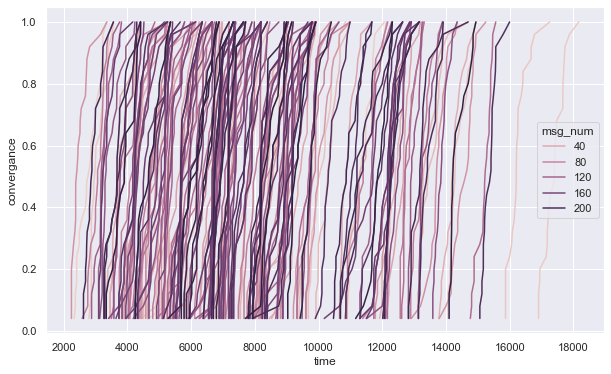

In [833]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
def conv(df):
    num_peers = len(df.columns)
    num_messages = len(df.index)
    
    
    a = df.values
    a.sort(axis=1)
    df2 = pd.DataFrame(a)
 

    df2.columns = ((i+1)/num_peers for i in df2.columns)
    df2.index = pd.RangeIndex(start=1, stop=num_messages+1, step=1)

    return df2.stack().reset_index().rename(columns={'level_0':'msg_num', 'level_1':'convergance', 0: 'time'})

def show_convergence(df):
    plt.figure(figsize=(10,6))
    sns.lineplot(x='time', y='convergance', data=conv(df), ci='sd', estimator="median", hue='msg_num')
    
show_convergence(df)

12. Save the new experiment settings.

In [835]:
sim_consensus.save_experiment(expr_dir='consensus', include_module_classes=True)